In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

## Load data & parameters

In [23]:
Smillie_marker      = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/colon_epithelial_marker.csv')
CellCycle_marker    = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/cell_cycle/cell_cycle_marker.tsv', sep='\t')
G2M_markers = list(CellCycle_marker[(CellCycle_marker['phase']=='G2/M')]['gene_symbol'])
S_markers   = list(CellCycle_marker[(CellCycle_marker['phase']=='S')]['gene_symbol'])

In [ ]:
adata_epi_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_epi_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [ ]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

In [83]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

In [30]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

## Cell cycle proportion → Unlikely

In [24]:
sc.tl.score_genes_cell_cycle(adata_epi_chen, S_markers, G2M_markers)
sc.tl.score_genes_cell_cycle(adata_epi_joanito, S_markers, G2M_markers)

/tmp/ipykernel_46852/2985854042.py:1: FutureWarning: The specified parameters ('s_genes', 'g2m_genes') are no longer positional. Please specify them like `s_genes=['UBR7', 'RFC2', 'RAD51', 'MCM2', 'TIPIN', 'MCM6', 'UNG', 'POLD3', 'WDR76', 'CLSPN', 'CDC45', 'CDC6', 'MSH2', 'MCM5', 'POLA1', 'MCM4', 'RAD51AP1', 'GMNN', 'RPA2', 'CASP8AP2', 'HELLS', 'E2F8', 'GINS2', 'PCNA', 'NASP', 'BRIP1', 'DSCC1', 'DTL', 'CDCA7', 'CENPU', 'ATAD2', 'CHAF1B', 'USP1', 'SLBP', 'RRM1', 'FEN1', 'RRM2', 'EXO1', 'CCNE2', 'TYMS', 'BLM', 'PRIM1', 'UHRF1']`
  sc.tl.score_genes_cell_cycle(adata_epi_chen, S_markers, G2M_markers)
/tmp/ipykernel_46852/2985854042.py:2: FutureWarning: The specified parameters ('s_genes', 'g2m_genes') are no longer positional. Please specify them like `s_genes=['UBR7', 'RFC2', 'RAD51', 'MCM2', 'TIPIN', 'MCM6', 'UNG', 'POLD3', 'WDR76', 'CLSPN', 'CDC45', 'CDC6', 'MSH2', 'MCM5', 'POLA1', 'MCM4', 'RAD51AP1', 'GMNN', 'RPA2', 'CASP8AP2', 'HELLS', 'E2F8', 'GINS2', 'PCNA', 'NASP', 'BRIP1', 'DSCC1'

### Chen et al

In [76]:
CellCycleProportion = list()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby("PatientID"):
    CellCycleProportion.append( [PatientID, 
                                 len(edf[edf['phase']=='S'])/len(edf), 
                                 len(edf[edf['phase']=='G1'])/len(edf), 
                                 len(edf[edf['phase']=='G2M'])/len(edf), 
                                 len(edf), ] )
CellCycleProportion = pd.DataFrame(CellCycleProportion, columns=['PatientID', 'S_perc', 'G1_perc', 'G2_perc', 'CellCount'])

/tmp/ipykernel_46852/1004102627.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen_tumor.obs.groupby("PatientID"):


<Axes: xlabel='PatientID', ylabel='S_perc'>

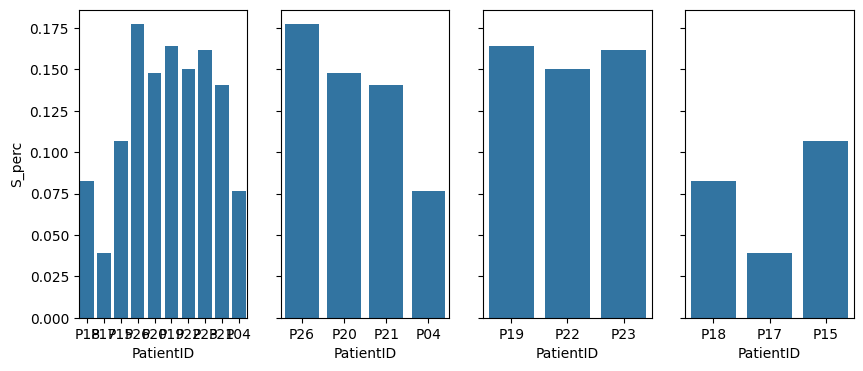

In [78]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
sns.barplot(data=CellCycleProportion, x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity, ax=axes[0])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_AC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_AC, ax=axes[1])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_TC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_TC, ax=axes[2])
sns.barplot(data=CellCycleProportion[CellCycleProportion['PatientID'].isin(chen_patient_order_by_MSI_intensity_SC)], 
            x='PatientID', y='S_perc', order=chen_patient_order_by_MSI_intensity_SC, ax=axes[3])

### Joanito et al

In [48]:
CellCycleProportion = list()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby("PatientID"):
    CellCycleProportion.append( [PatientID, 
                                 len(edf[edf['phase']=='S'])/len(edf), 
                                 len(edf[edf['phase']=='G1'])/len(edf), 
                                 len(edf[edf['phase']=='G2M'])/len(edf), 
                                 len(edf), ] )
CellCycleProportion = pd.DataFrame(CellCycleProportion, columns=['PatientID', 'S_perc', 'G1_perc', 'G2_perc', 'CellCount'])

/tmp/ipykernel_46852/2305206005.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_joanito_tumor.obs.groupby("PatientID"):


<Axes: xlabel='PatientID', ylabel='G2_perc'>

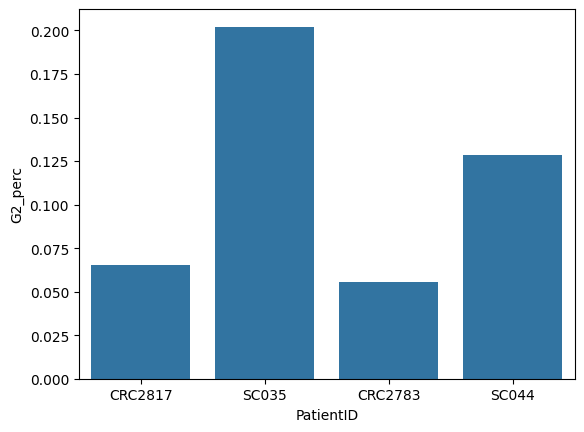

In [52]:
sns.barplot(data=CellCycleProportion, x='PatientID', y='S_perc', order=joanito_patient_order_by_MSI_intensity)

## Colon epithelial identity → Unlikely

### Chen et al

In [55]:
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Stem']['gene'], score_name='stem_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Goblet']['gene'], score_name='goblet_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='Enterocytes']['gene'], score_name='enterocyte_score')
sc.tl.score_genes(adata_epi_chen_tumor, Smillie_marker[Smillie_marker['ident']=='E.Epithelial']['gene'], score_name='epithelial_score')

       'RP11-290L1.2', 'GYLTL1B', 'AP003774.1', 'AP000344.3', 'RP11-760H22.2',
       'ATP5G1', 'RP11-435O5.2', 'RP11-519G16.5', 'FAM84A', 'ADCK3', 'NGFRAP1',
       'RPSAP58'],
      dtype='object')
       'CTD-2589M5.4', 'RP3-340N1.5', 'FAM101A', 'MT-RNR2', 'MFSD4',
       'RP11-665N17.4', 'RP11-48O20.4', 'RP11-845C23.2', 'RP11-757F18.5',
       'RP11-92K15.3', 'GAREM'],
      dtype='object')
       'RP11-125B21.2', 'C12orf36', 'RP11-426L16.3', 'SEPP1', 'LINC00704',
       'MIR4435-1HG', 'CTC-490G23.2', 'LINC00035', 'GPR110', 'C1orf106',
       'RP11-202A13.1', 'CTB-171A8.1', 'RP11-35P15.1', 'RP11-30P6.6',
       'RP11-542M13.2'],
      dtype='object')
       'RP11-680F8.1', 'CTD-2547H18.1', 'MIR194-2', 'CTB-175P5.4',
       'RP11-30P6.6', 'AC009014.3', 'AC011298.2', 'AC106876.2', 'RP11-35P15.1',
       'C3orf83', 'RP11-187E13.1', 'RP11-465B22.8', 'RP11-542M13.2',
       'RP11-297L17.2', 'RP11-395B7.2', 'LINC00035'],
      dtype='object')


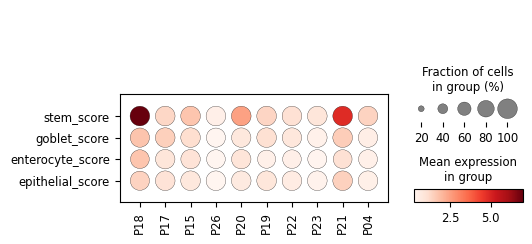

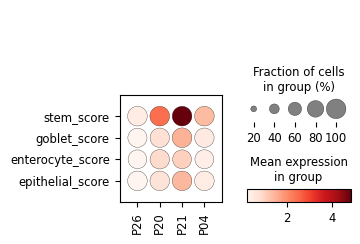

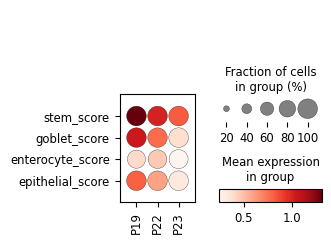

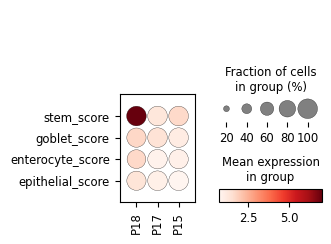

In [80]:
sc.pl.dotplot(adata_epi_chen_tumor, 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

### Joanito et al

In [64]:
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Stem']['gene'], score_name='stem_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Goblet']['gene'], score_name='goblet_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='Enterocytes']['gene'], score_name='enterocyte_score')
sc.tl.score_genes(adata_epi_joanito_tumor, Smillie_marker[Smillie_marker['ident']=='E.Epithelial']['gene'], score_name='epithelial_score')

       'RP11-290L1.2', 'GYLTL1B', 'AP003774.1', 'AP000344.3', 'RP11-760H22.2',
       'ATP5G1', 'RP11-435O5.2', 'RP11-519G16.5', 'FAM84A', 'ADCK3', 'NGFRAP1',
       'RPSAP58'],
      dtype='object')
       'CTD-2589M5.4', 'RP3-340N1.5', 'FAM101A', 'MT-RNR2', 'MFSD4',
       'RP11-665N17.4', 'RP11-48O20.4', 'RP11-845C23.2', 'RP11-757F18.5',
       'RP11-92K15.3', 'GAREM'],
      dtype='object')
       'RP11-125B21.2', 'C12orf36', 'RP11-426L16.3', 'SEPP1', 'LINC00955',
       'LINC00704', 'MIR4435-1HG', 'CTC-490G23.2', 'LINC00035', 'GPR110',
       'C1orf106', 'RP11-202A13.1', 'CTB-171A8.1', 'RP11-35P15.1',
       'RP11-30P6.6', 'RP11-542M13.2'],
      dtype='object')
       'RP11-680F8.1', 'CTD-2547H18.1', 'MIR194-2', 'CTB-175P5.4',
       'RP11-30P6.6', 'AC009014.3', 'AC011298.2', 'AC106876.2', 'RP11-35P15.1',
       'C3orf83', 'RP11-187E13.1', 'RP11-465B22.8', 'RP11-542M13.2',
       'RP11-297L17.2', 'RP11-395B7.2', 'LINC00035'],
      dtype='object')


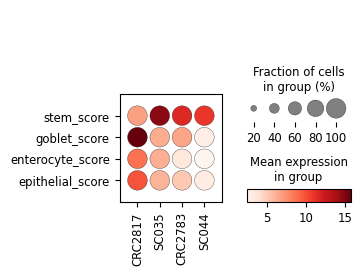

In [65]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=['stem_score', 'goblet_score', 'enterocyte_score', 'epithelial_score'], 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

## Relevant genes (MMR, Methylation, etc.) → Unlikely

In [110]:
RelevantGenes = {
    'Methylation' : ['DNMT3A', 'DNMT3B', 'DNMT1', 'UHRF1'],
    'Demethylation' : ['TET1', 'TET2', 'TET3'],
    'MMR' : ['MLH1', 'MSH2', 'MSH6'],
    'BRAF' : ['BRAF', 'KRAS', 'NRAS'],
    # 'APG' : ['HLA-A', 'HLA-B', 'HLA-C', 'TAP1', 'TAP2', 'B2M'],
    'Misc' : ['MUC2', 'MUC5AC', 'OLFM4'],
}

### Chen et al

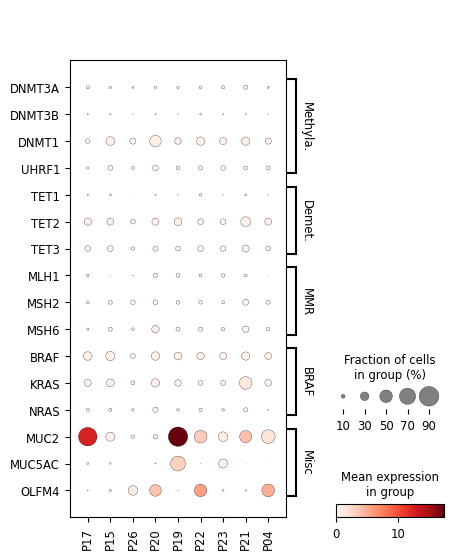

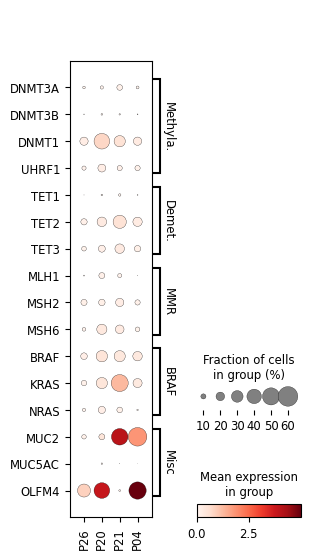

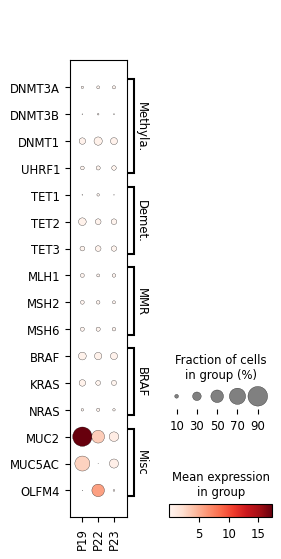

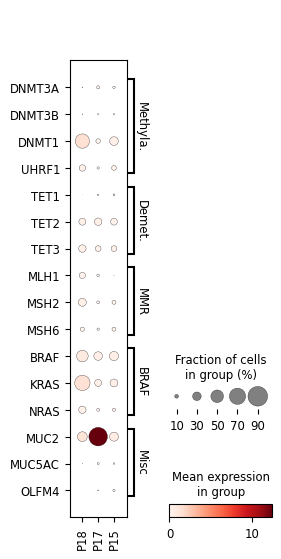

In [111]:

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

### Joanito et al

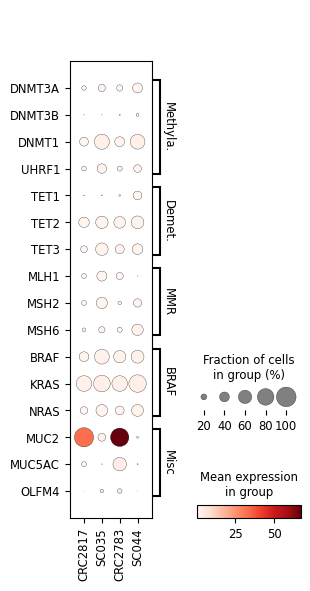

In [112]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=RelevantGenes, 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

## Association with tumor regression after ICI (Chen)

In [119]:
MSI_degree = list()
for PatientID, edf in adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby("PatientID"):
    MSI_degree.append( [PatientID, np.mean(edf['AvgSTRDiff'].dropna()), 
                        len(edf),
                        edf.iloc[0].Age, edf.iloc[0].CancerType, edf.iloc[0].TumorLocation, edf.iloc[0].TumorStage, edf.iloc[0].TumorRegressionRatio, edf.iloc[0].Response
                        ] )
MSI_degree = pd.DataFrame(MSI_degree, columns=['PatientID', 'AvgSTRDiff', 'CellCount', 
                                               'Age', 'CancerType', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'Response'])
MSI_degree.sort_values('AvgSTRDiff', ascending=False, inplace=True)

/tmp/ipykernel_46852/1781796067.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen[adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby("PatientID"):


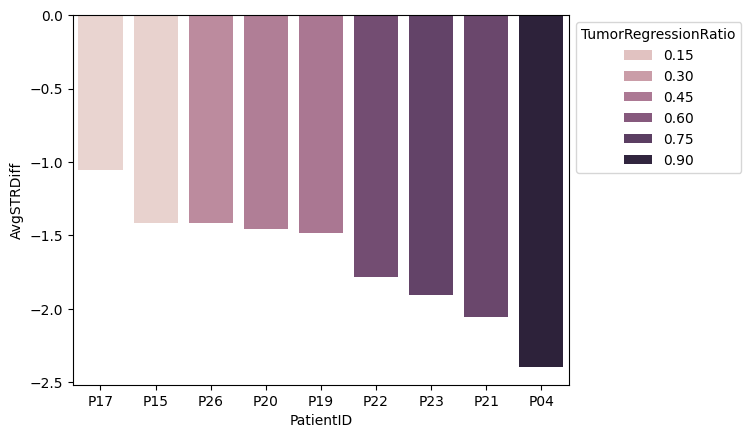

In [120]:
ax = sns.barplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['PatientID']!='P18')], x='PatientID', y='AvgSTRDiff', 
                 hue='TumorRegressionRatio', 
                 # palette=sns.diverging_palette(220, 20, as_cmap=True),
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [117]:
for TumorLoc in [ ['Ascending colon'], ['Transverse colon'], ['Sigmoid colon'], 
                 ['Ascending colon', 'Transverse colon'], ['Transverse colon', 'Sigmoid colon'], ['Ascending colon', 'Sigmoid colon'], 
                 ['Ascending colon', 'Transverse colon', 'Sigmoid colon'] ]: # MSI_degree[MSI_degree['CancerType']=='CRC']
    MSI_degree_oi = MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['TumorLocation'].isin(TumorLoc))]
    r, pval = stats.pearsonr(MSI_degree_oi['AvgSTRDiff'], MSI_degree_oi['TumorRegressionRatio'])
    print(len(TumorLoc), len(MSI_degree_oi), round(r, 3), round(100*pval, 2))
    

1 4 -0.996 0.38
1 3 -0.997 4.73
1 3 0.871 32.64
2 7 -0.978 0.01
2 6 -0.093 86.06
2 7 -0.379 40.23
3 10 -0.436 20.73


In [ ]:
""" 
1 4 -0.997 0.31		AC
1 3 -0.995 6.43		TC
1 3 0.876 32.03		SC

2 7 -0.979 0.01		AC x TC
2 6 -0.097 85.57	TC x SC
2 7 -0.384 39.52	AC x SC

3 10 -0.441 20.18	AC x TC x SC
"""

<Axes: xlabel='AvgSTRDiff', ylabel='TumorRegressionRatio'>

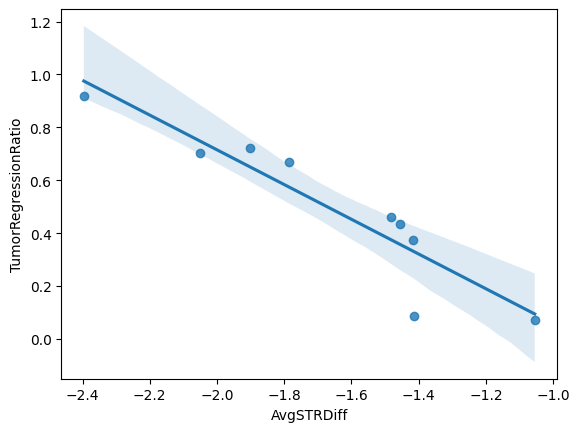

In [118]:
sns.regplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & (MSI_degree['PatientID']!='P18')], x='AvgSTRDiff', y='TumorRegressionRatio', )

## XGBoost

### Joanito et al

In [138]:
import numpy as np
import pandas as pd

minimum_loci = 10

# Features: Gene expression matrix
X = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_joanito_tumor.X, np.ndarray) else adata_epi_joanito_tumor.X.toarray()  # Ensure dense format

# Target variable
y = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].obs['AvgSTRDiff'].values

In [139]:
X_hvg = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_joanito_tumor.X, np.ndarray) else adata_epi_joanito_tumor.X.toarray()

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [142]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.1 MB/s eta 0:00:00a 0:00:01


In [143]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [144]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.13126127560921672
R² Score: 0.7622287565782708


In [146]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_hvg, y, scoring='r2', cv=5)
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores)}")

Cross-Validation R² Scores: [-0.54153736  0.38291907 -0.18609678  0.1039896  -0.62732391]
Mean R² Score: -0.1736098779559035


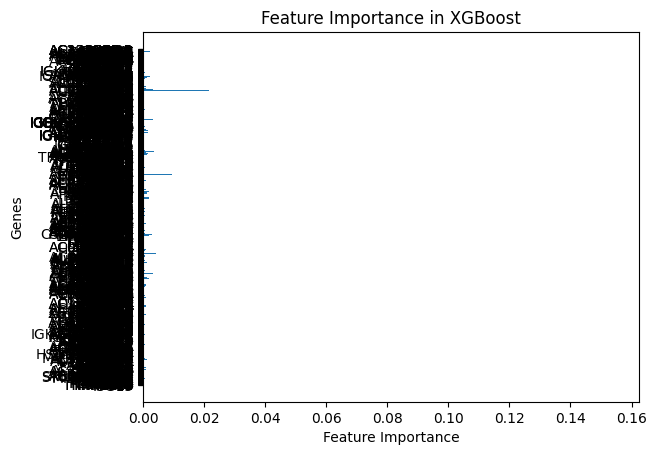

In [147]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.barh(adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].var_names, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Genes')
plt.title('Feature Importance in XGBoost')
plt.show()

In [150]:
for idx, fi in enumerate(model.feature_importances_):
    if fi > 0.1:
        print(idx, fi)

96 0.15484539
1555 0.11057895


In [156]:
adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[96]

'S100A6'

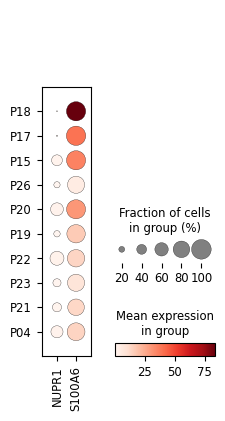

In [160]:
sc.pl.dotplot(adata_epi_chen_tumor, var_names=['NUPR1', 'S100A6'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity)

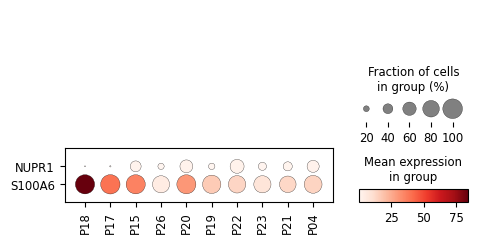

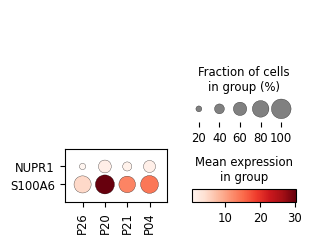

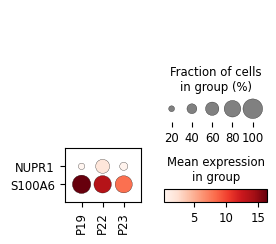

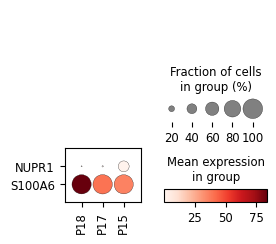

In [162]:
sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

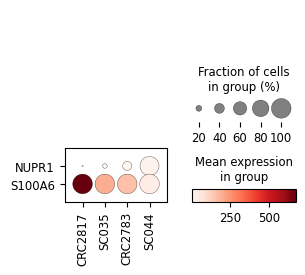

In [163]:
sc.pl.dotplot(adata_epi_joanito_tumor, 
              var_names=['NUPR1', 'S100A6'], 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)

### Chen et al

In [183]:
import numpy as np
import pandas as pd

minimum_loci = 10

# Features: Gene expression matrix
X = adata_epi_chen_tumor[(adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci) & 
                         (adata_epi_chen_tumor.obs['CancerLocation']=='Ascending colon')].X if isinstance(adata_epi_chen_tumor.X, np.ndarray) else adata_epi_chen_tumor.X.toarray()  # Ensure dense format

# Target variable
y = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].obs['AvgSTRDiff'].values

KeyError: 'CancerLocation'

In [165]:
X_hvg = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].X if isinstance(adata_epi_chen_tumor.X, np.ndarray) else adata_epi_chen_tumor.X.toarray()

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_hvg, y, test_size=0.2, random_state=42)

In [171]:
model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Depth of each tree
    random_state=42               # For reproducibility
)

In [172]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [173]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.22426259469956675
R² Score: 0.5297943110241861


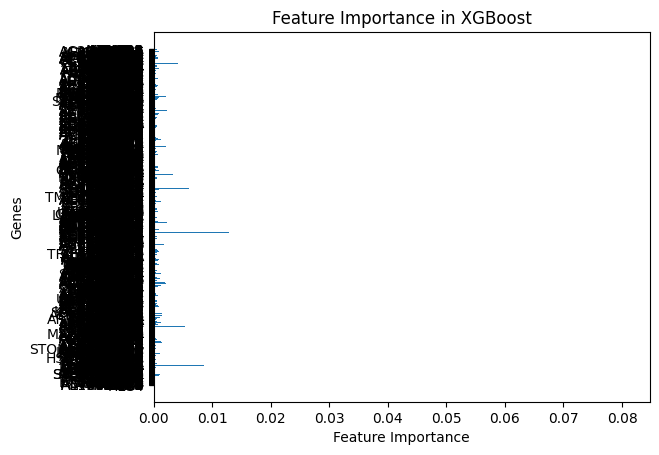

In [175]:

# Plot feature importance
plt.barh(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Genes')
plt.title('Feature Importance in XGBoost')
plt.show()

In [176]:
max(model.feature_importances_)

0.08068145

In [180]:
candidate_genes = list()
for idx, fi in enumerate(model.feature_importances_):
    if fi > 0.008:
        print(idx, fi, adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[idx])
        candidate_genes.append(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['NumSTRLoci']>=minimum_loci].var_names[idx])

92 0.016063951 REG4
115 0.008570226 S100A6
241 0.01597191 REG1A
907 0.012797859 GRM8
1045 0.025614126 PRUNE2
1081 0.08068145 AKR1C1
1394 0.0080348225 OLFM4
1522 0.02670309 GCNT3


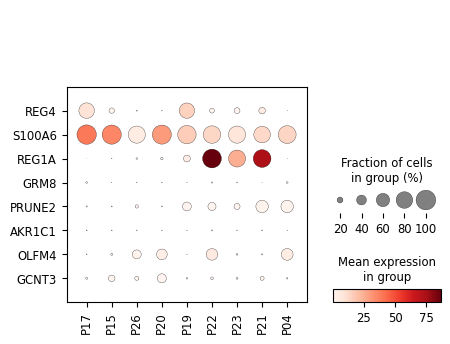

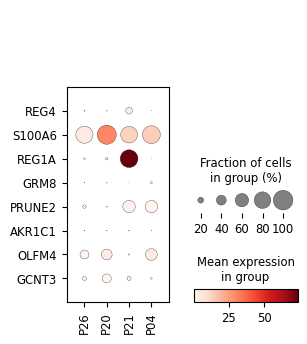

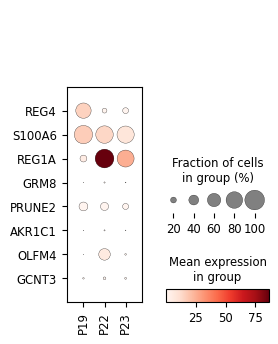

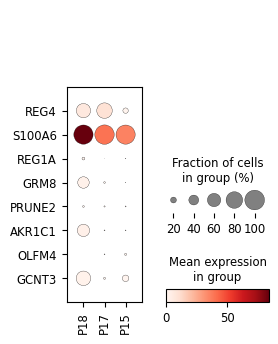

In [181]:
sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID']!='P18'], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_P18, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_AC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_AC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_TC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_TC, swap_axes=True)

sc.pl.dotplot(adata_epi_chen_tumor[adata_epi_chen_tumor.obs['PatientID'].isin( chen_patient_order_by_MSI_intensity_SC )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=chen_patient_order_by_MSI_intensity_SC, swap_axes=True)

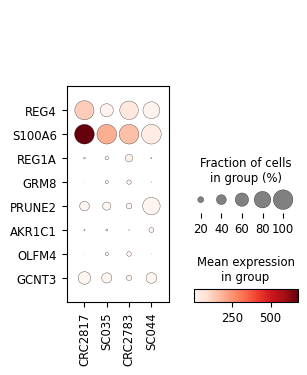

In [182]:
sc.pl.dotplot(adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['PatientID'].isin( joanito_patient_order_by_MSI_intensity )], 
              var_names=candidate_genes, 
              groupby='PatientID', 
              categories_order=joanito_patient_order_by_MSI_intensity, swap_axes=True)